**Image Segmentation with U-Net**

In this notebook, we build a U-Net, a type of CNN designed for quick, precise image segmentation, and using it to predict a label for every single pixel in an image - in this case, an image from a rover on Mars.


# 1 - Packages

In [ ]:
# Usefull import
import numpy as np
import matplotlib.pyplot as plt
import requests
import zipfile
import os
import random
import matplotlib.image as mpimg
from PIL import Image

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate


# 2 - Load and Split the Data

In [ ]:
# Download the data (takes about 5 minutes)

url = "https://data.nasa.gov/download/cykx-2qix/application%2Fzip"
response = requests.get(url, stream=True)

with open("ai4mars-dataset-merged-0.1.zip", mode="wb") as file:
     for chunk in response.iter_content(chunk_size=10 * 1024):
         file.write(chunk)

In [ ]:
# Path to the zip file
zip_file_path = '/content/ai4mars-dataset-merged-0.1.zip'

# Directory where you want to extract the data
extracted_folder_path = '/content/Data_extracted'

# Create the directory if it doesn't exist
os.makedirs(extracted_folder_path, exist_ok=True)

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

print(f"Data extracted to {extracted_folder_path}")


Data extracted to /content/Data_extracted


In [ ]:
# Get rid of the images without label

# Directory containing the extracted data
data_folder = '/content/Data_extracted/ai4mars-dataset-merged-0.1/msl'

# Paths to the "edr" images and "train" labels
edr_folder = os.path.join(data_folder, 'images', 'edr')
train_labels_folder = os.path.join(data_folder, 'labels', 'train')

# Get a list of image files in the "edr" folder
edr_image_files = sorted([f for f in os.listdir(edr_folder) if f.endswith('.JPG') or f.endswith('.png')])
print("Number of images before : ", len(edr_image_files))

# Get a list of image files in the "edr" folder
label_files = sorted([f for f in os.listdir(train_labels_folder) if f.endswith('.JPG') or f.endswith('.png')])

image_files = []
for label in label_files :
  # label_path = os.path.join(train_labels_folder, image.replace('.JPG', '.png'))
  if label.replace('.png', '.JPG') in edr_image_files:
    image_files.append(label.replace('.png', '.JPG'))

print("Number of images before : ", len(image_files))
print("Number of label available : ", len(label_files))


Number of images before :  18127
Number of images before :  16064
Number of label available :  16064


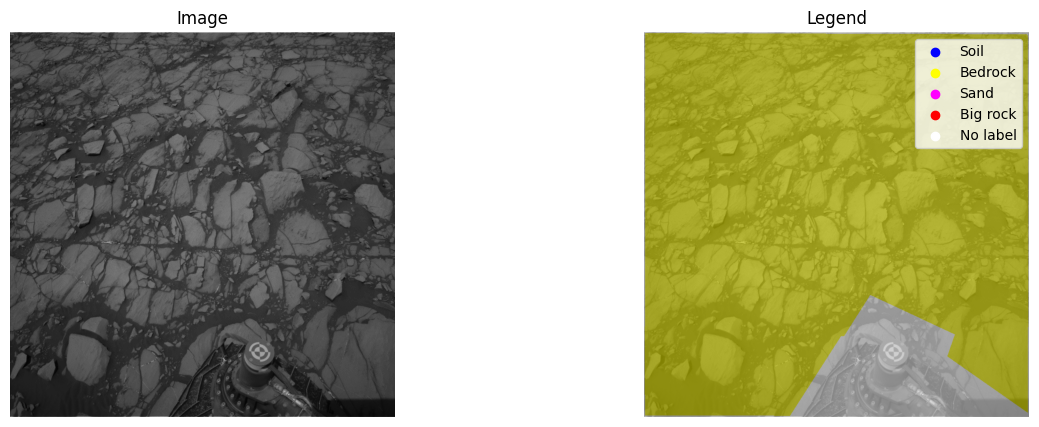

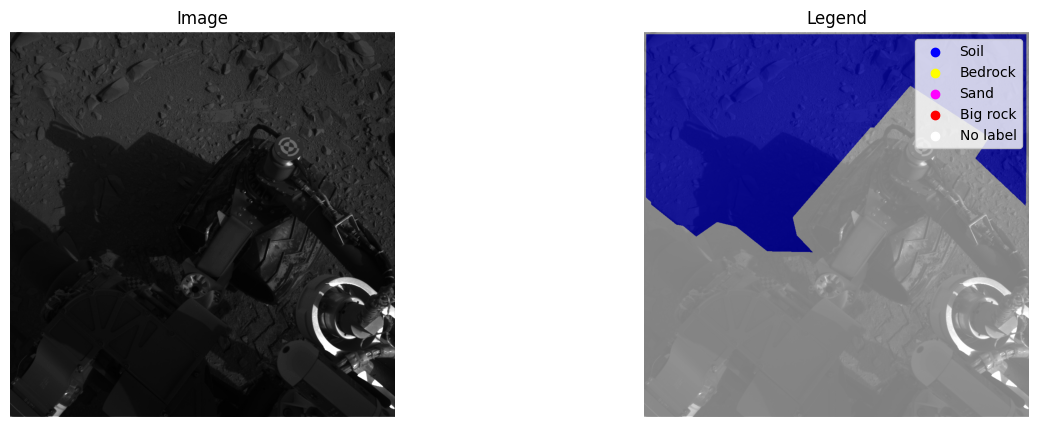

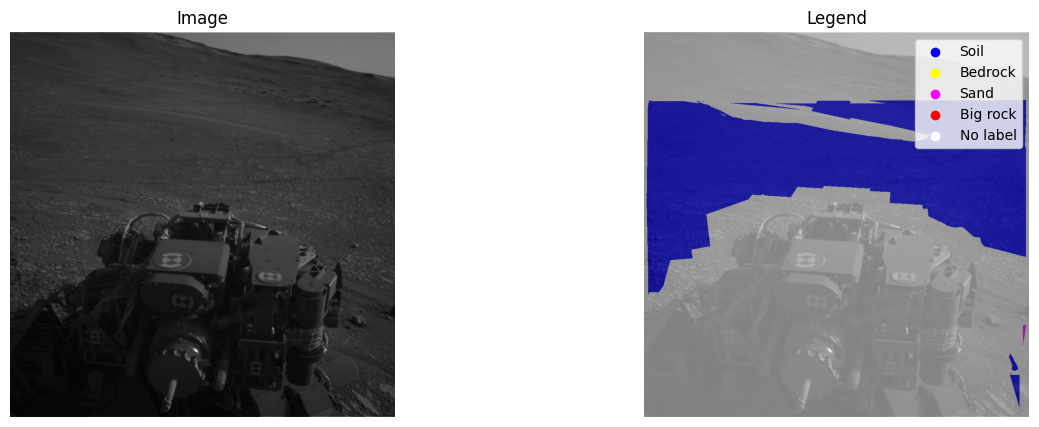

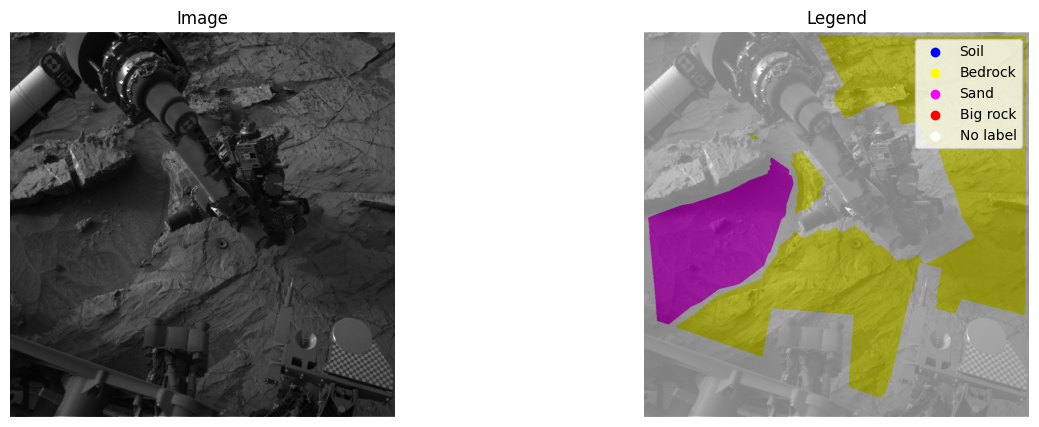

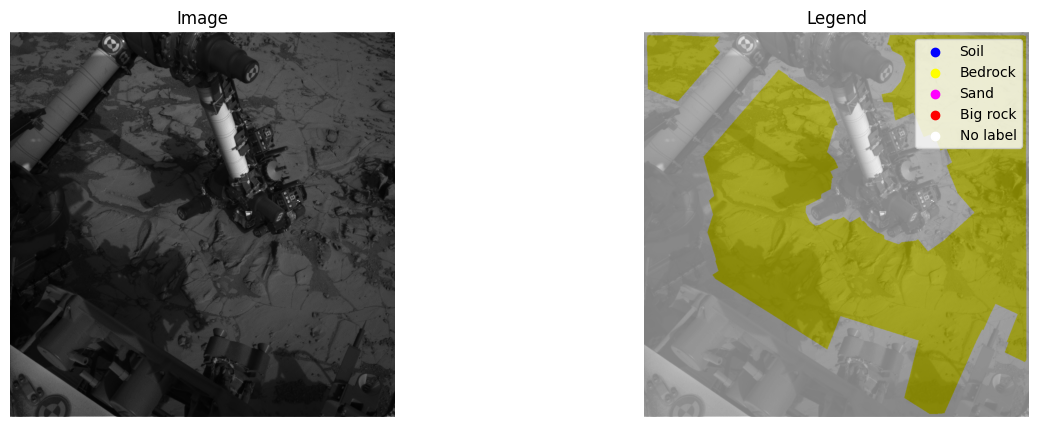

In [ ]:
# Display some images and their corresponding label

# Label color mapping
label_colors = {
    0: [0, 0, 255],   # blue for soil
    1: [255, 255,0],   # yellow for bedrock
    2: [255, 0, 255],   # purple for sand
    3: [255, 0, 0],     # red for big rock
    255: [255, 255, 255]  # white for NULL
}
label_names = {
    0: "Soil",
    1: "Bedrock",
    2: "Sand",
    3: "Big rock",
    255: "No label"
}

# Display a few random training images and their corresponding labels with transparent masks
num_images_to_display = 5

for _ in range(num_images_to_display):
    random_image = random.choice(image_files)
    image_path = os.path.join(edr_folder, random_image)
    label_path = os.path.join(train_labels_folder, random_image.replace('.JPG', '.png'))

    if not  os.path.isfile(label_path) :
      print("No label found")
      continue

    # Load and display the "edr" image (grayscale)
    img_edr = Image.open(image_path)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_edr, cmap='gray')  # Use a grayscale colormap
    plt.title("Image")
    plt.axis('off')

    # Load and display the corresponding label from the "train" folder (apply color mapping)
    img_label = Image.open(label_path)
    label_array = np.array(img_label)

    # Create a transparent mask based on label colors
    mask = np.zeros((1024,1024,3))
    for label_value, color in label_colors.items():
        mask[label_array == label_value] = color

    plt.subplot(1, 2, 2)
    plt.imshow(img_edr, cmap='gray')  # Original image
    plt.imshow(mask, alpha = 0.5)  # Overlay mask
    plt.title("Image with Segmentation")
    plt.axis('off')

    # Display the legend
    plt.subplot(1, 2, 2)
    for label_value, color in label_colors.items():
        plt.scatter([], [], color=np.array(color[:3]) / 255.0, label=f'{label_names[label_value]}')
    plt.title("Legend")
    plt.axis('off')
    plt.legend()

    plt.show()

In [ ]:
# change "no label" from 255 to 4, takes about 5 minutes

i = 0
for label in label_files :
  label_path = os.path.join(train_labels_folder,label)
  img_label = Image.open(label_path)
  label_array = np.array(img_label)
  label_array[label_array == 255] = 4
  im = Image.fromarray(label_array)
  im.save(label_path)
  if i % 1000 == 0 :
    print(i)
  i+=1



0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000


## 2.1 - Split the dataset into Unmasked and Masked Images


In [ ]:
image_list = [edr_folder+'/'+i for i in image_files]
mask_list = [train_labels_folder+'/'+i for i in label_files]

image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/Data_extracted/ai4mars-dataset-merged-0.1/msl/images/edr/NLA_397586934EDR_F0010008AUT_04096M1.JPG'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/Data_extracted/ai4mars-dataset-merged-0.1/msl/labels/train/NLA_397586934EDR_F0010008AUT_04096M1.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/Data_extracted/ai4mars-dataset-merged-0.1/msl/images/edr/NLA_397681339EDR_F0020000AUT_04096M1.JPG'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/Data_extracted/ai4mars-dataset-merged-0.1/msl/labels/train/NLA_397681339EDR_F0020000AUT_04096M1.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/Data_extracted/ai4mars-dataset-merged-0.1/msl/images/edr/NLA_397681372EDR_F0020000AUT_04096M1.JPG'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/Data_extracted/ai4mars-dataset-merged-0.1/msl/labels/train/NLA_397681372EDR_F0020000AUT_04096M1.png'>)


In [ ]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/content/Data_extracted/ai4mars-dataset-merged-0.1/msl/images/edr/NLA_397586934EDR_F0010008AUT_04096M1.JPG', shape=(), dtype=string)
tf.Tensor(b'/content/Data_extracted/ai4mars-dataset-merged-0.1/msl/labels/train/NLA_397586934EDR_F0010008AUT_04096M1.png', shape=(), dtype=string)


## 2.2 Preprocess the data

In [ ]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (128, 128), method='nearest')
    input_mask = tf.image.resize(mask, (128, 128), method='nearest')


    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

# 3 - U-Net

In [ ]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block

    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns:
        next_layer, skip_connection --  Next layer and skip connection outputs
    """
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(rate = dropout_prob,
                       noise_shape=None,
                       seed=None)(conv)


    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2, 2))(conv)

    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block

    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns:
        conv -- Tensor output
    """

    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)

    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                  # set 'kernel_initializer' same as above
                 kernel_initializer='he_normal')(conv)


    return conv

In [ ]:
def unet_model(input_size=(128, 128, 1), n_filters=32, n_classes=5):
    """
    Unet model

    Arguments:
        input_size -- Input shape
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns:
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters)
    # Chain the first element of the output of each block to be the input of the next conv_block.
    # Double the number of filters at each new step
    cblock2 = conv_block(inputs = cblock1[0], n_filters = 2 * n_filters)
    cblock3 = conv_block(inputs = cblock2[0], n_filters = 4 * n_filters)
    cblock4 = conv_block(cblock3[0], 8 * n_filters,dropout_prob = 0.3) # Include a dropout_prob of 0.3 for this layer
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], 16 * n_filters, dropout_prob=0.3, max_pooling=False)

    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8

    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters * 8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer.
    # At each step, use half the number of filters of the previous block
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters * 1)


    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 # set 'kernel_initializer' same as above exercises
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)


    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
img_height = 128
img_width = 128
num_chanels = 1

unet = unet_model((img_height, img_width, num_chanels))
print(unet.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
# Loss function

unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    # Label color mapping
    label_colors = {
        0: [0, 0, 255],   # blue for soil
        1: [255, 255,0],   # yellow for bedrock
        2: [255, 0, 255],   # purple for sand
        3: [255, 0, 0],     # red for big rock
        4: [255, 255, 255]  # white for NULL
    }
    label_names = {
        0: "Soil",
        1: "Bedrock",
        2: "Sand",
        3: "Big rock",
        4: "No label"
    }

    plt.subplot(1, len(display_list), 1)
    plt.title(title[0])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[0]), cmap='gray')
    plt.axis('off')

    # Create a transparent mask based on label colors
    mask = np.zeros((*tf.squeeze(display_list[1],axis = -1).shape, 3))
    print("mask shape : ", mask.shape)
    print("label array shape : ", display_list[1].shape)
    for label_value, color in label_colors.items():
      # indices = display_list[1] == label_value
      # indices =
      mask[tf.squeeze(display_list[1] == label_value,axis=-1),:] = np.array(color)

    plt.subplot(1, len(display_list), 2)
    plt.imshow(mask)
    for label_value, color in label_colors.items():
        plt.scatter([], [], color=np.array(color[:3]) / 255.0, label=f'{label_names[label_value]}')
    plt.title(title[1])
    plt.legend()
    plt.axis('off')

    if len(display_list) > 2 :
      mask = np.zeros((*tf.squeeze(display_list[2],axis = -1).shape, 3))
      for label_value, color in label_colors.items():
        mask[tf.squeeze(display_list[2] == label_value,axis=-1),:] = np.array(color)

      plt.subplot(1, len(display_list), 3)
      plt.imshow(mask)
      print('predicted shape :', display_list[2].shape)
      for label_value, color in label_colors.items():
          plt.scatter([], [], color=np.array(color[:3]) / 255.0, label=f'{label_names[label_value]}')
      plt.title(title[2])
      plt.legend()
      plt.axis('off')



mask shape :  (1024, 1024, 3)
label array shape :  (1024, 1024, 1)


mask shape :  (1024, 1024, 3)
label array shape :  (1024, 1024, 1)
mask shape :  (1024, 1024, 3)
label array shape :  (1024, 1024, 1)


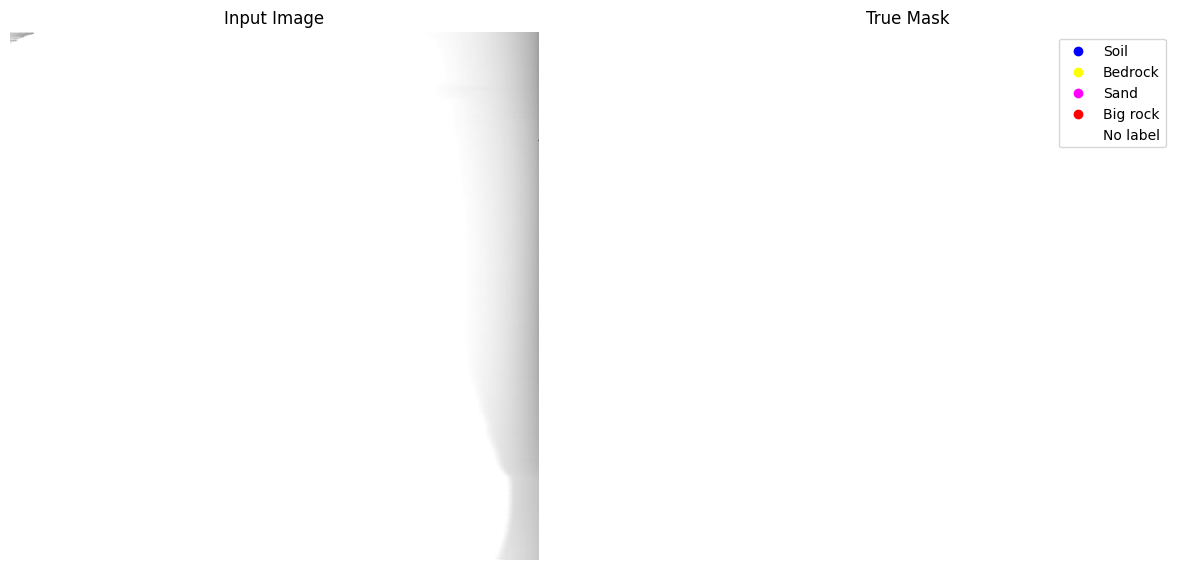

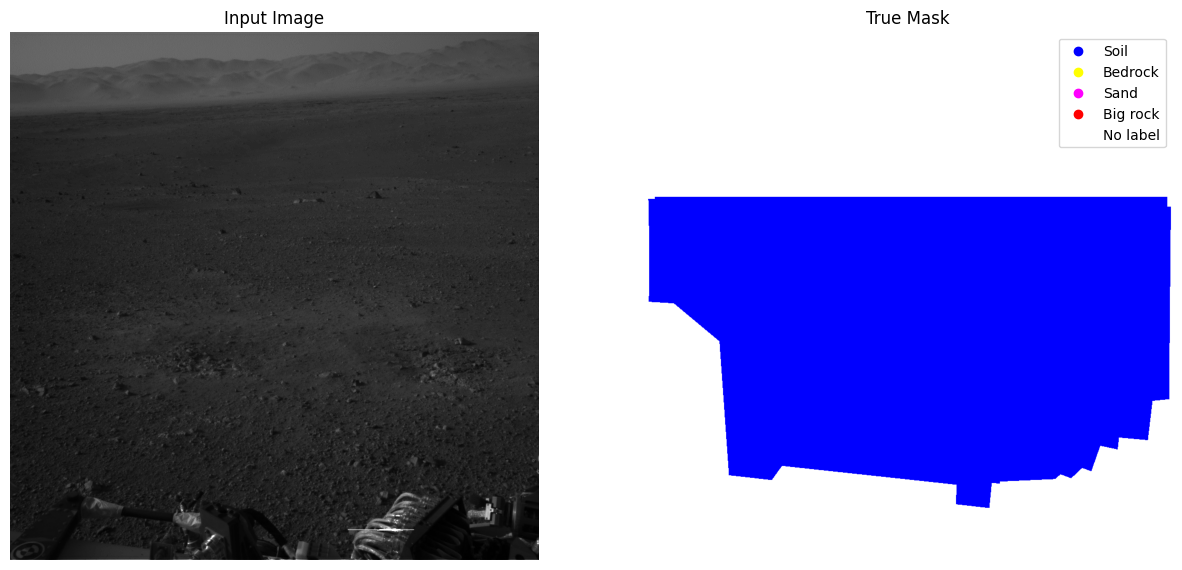

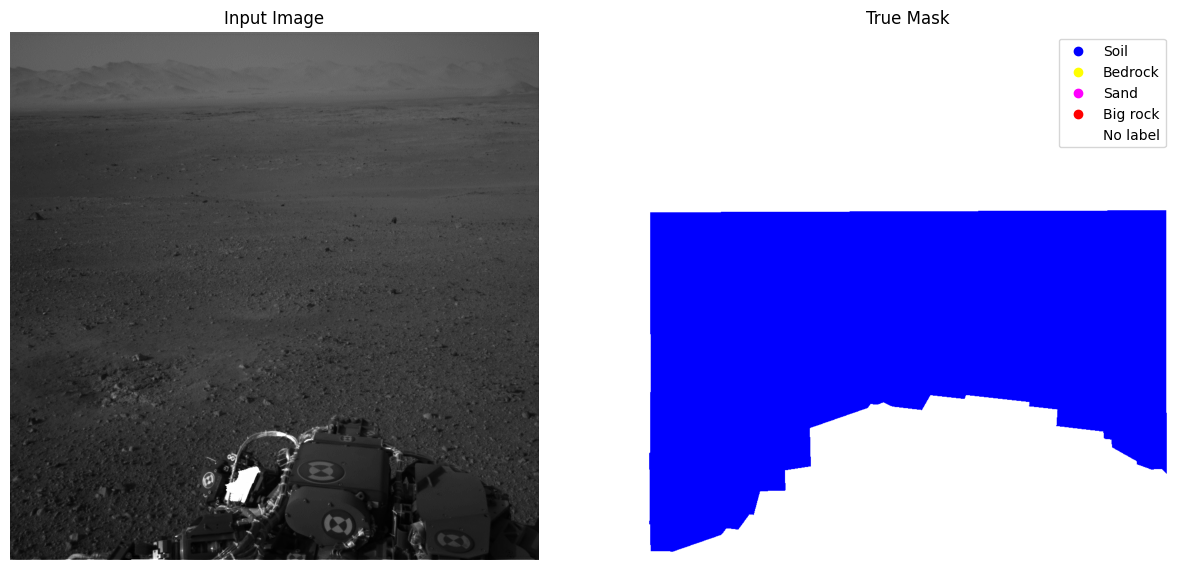

In [ ]:
for image, mask in image_ds.take(3):
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])

# 4 - Train the model

Epoch 1/5
502/502 [==============================] - 8839s 18s/step - loss: 0.9451 - accuracy: 0.6460
Epoch 2/5
502/502 [==============================] - 8589s 17s/step - loss: 0.7013 - accuracy: 0.7215
Epoch 3/5
502/502 [==============================] - 8555s 17s/step - loss: 0.6920 - accuracy: 0.7359
Epoch 4/5
502/502 [==============================] - 8565s 17s/step - loss: 0.5693 - accuracy: 0.7851
Epoch 5/5
225/502 [============>.................] - ETA: 1:19:39 - loss: 0.5273 - accuracy: 0.8061

In [ ]:
EPOCHS = 5
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)

checkpoint_path = "/content/drive/MyDrive/Deep_learning_projects/training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

(TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))


In [ ]:
# Load the weights from a previous training
unet.load_weights(checkpoint_path)

In [ ]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model_history = unet.fit(train_dataset, epochs=EPOCHS, callbacks=[cp_callback])

# save the model weights
unet.save('/content/drive/MyDrive/Deep_learning_projects/saved_model/my_model_2')

Epoch 1/5
502/502 [==============================] - ETA: 0s - loss: 0.4557 - accuracy: 0.8238 
Epoch 1: saving model to /content/drive/MyDrive/Deep_learning_projects/training_2/cp.ckpt
502/502 [==============================] - 9211s 18s/step - loss: 0.4557 - accuracy: 0.8238
Epoch 2/5
502/502 [==============================] - ETA: 0s - loss: 0.4307 - accuracy: 0.8323 
Epoch 2: saving model to /content/drive/MyDrive/Deep_learning_projects/training_2/cp.ckpt
502/502 [==============================] - 8781s 17s/step - loss: 0.4307 - accuracy: 0.8323
Epoch 3/5
203/502 [===========>..................] - ETA: 1:26:57 - loss: 0.4266 - accuracy: 0.8404

## 4.1 - Create Predicted Masks

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

## 4.2 - Plot Model Accuracy

In [ ]:
plt.plot(model_history.history["accuracy"])

NameError: name 'model_history' is not defined

## 4.3 - Show Predictions

In [ ]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            print("mask shape 2 ", mask.shape,mask[0].shape)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 5s 5s/step


mask shape 2  (32, 128, 128, 1) (128, 128, 1)
mask shape :  (128, 128, 3)
label array shape :  (128, 128, 1)
predicted shape : (128, 128, 1)
1/1 [==============================] - 7s 7s/step


mask shape 2  (32, 128, 128, 1) (128, 128, 1)
mask shape :  (128, 128, 3)
label array shape :  (128, 128, 1)
predicted shape : (128, 128, 1)
1/1 [==============================] - 4s 4s/step


mask shape 2  (32, 128, 128, 1) (128, 128, 1)
mask shape :  (128, 128, 3)
label array shape :  (128, 128, 1)
predicted shape : (128, 128, 1)
1/1 [==============================] - 7s 7s/step


mask shape 2  (32, 128, 128, 1) (128, 128, 1)
mask shape :  (128, 128, 3)
label array shape :  (128, 128, 1)
predicted shape : (128, 128, 1)
1/1 [==============================] - 5s 5s/step


mask shape 2  (32, 128, 128, 1) (128, 128, 1)
mask shape :  (128, 128, 3)
label array shape :  (128, 128, 1)
predicted shape : (128, 128, 1)


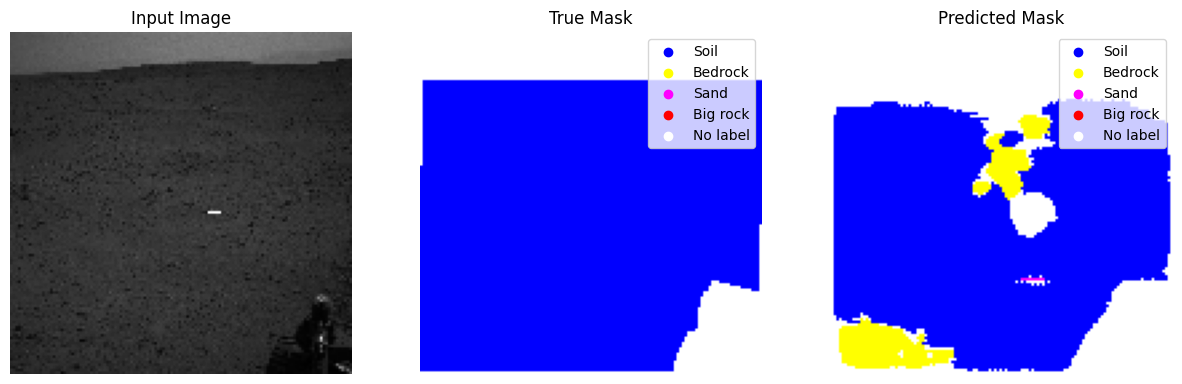

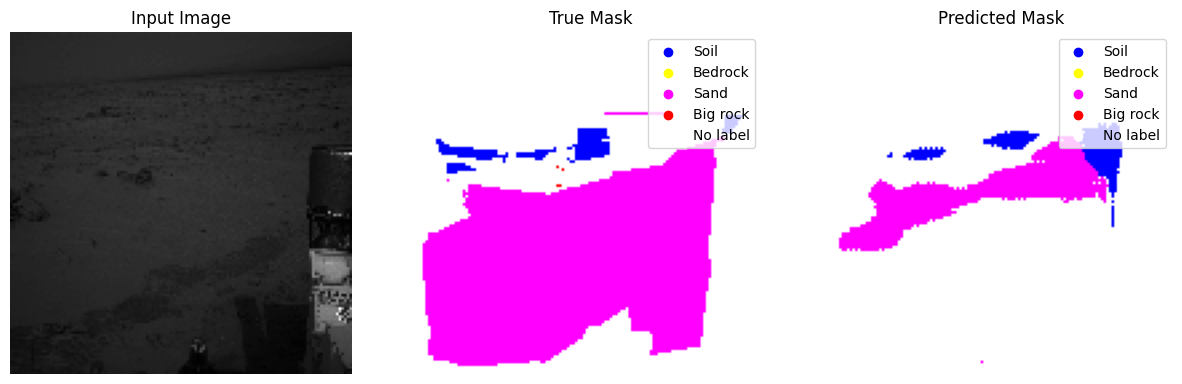

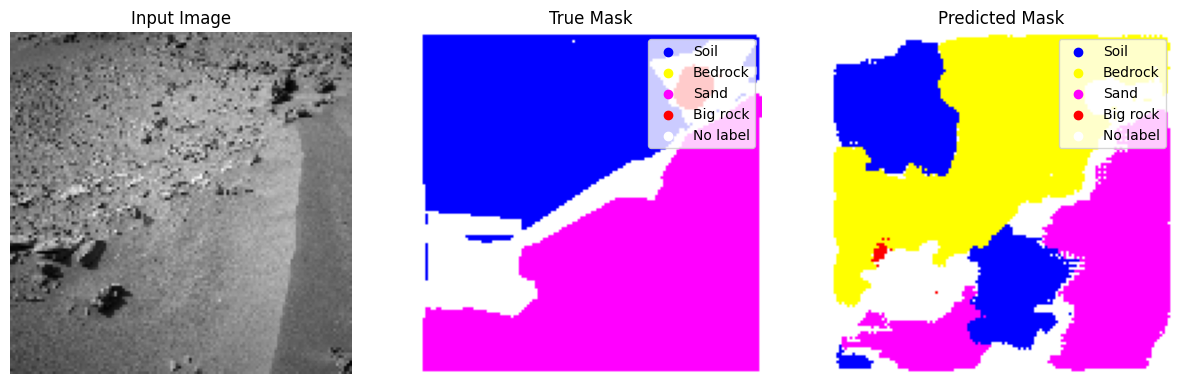

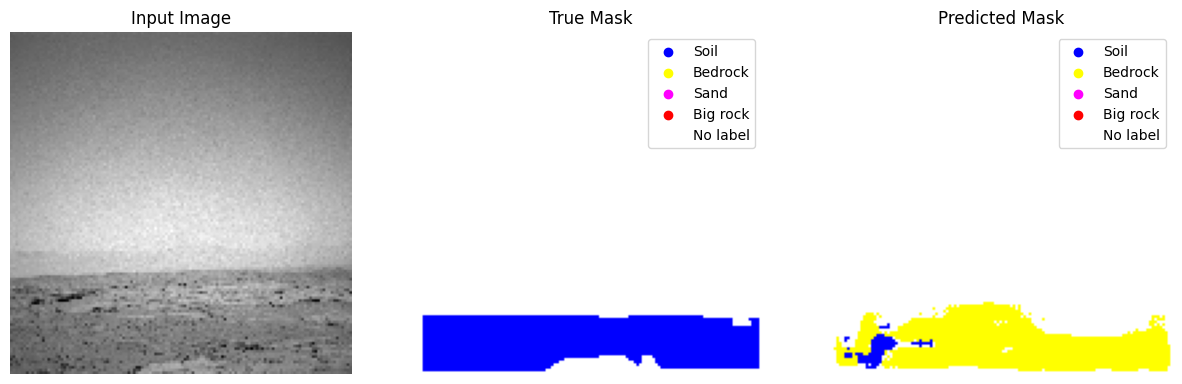

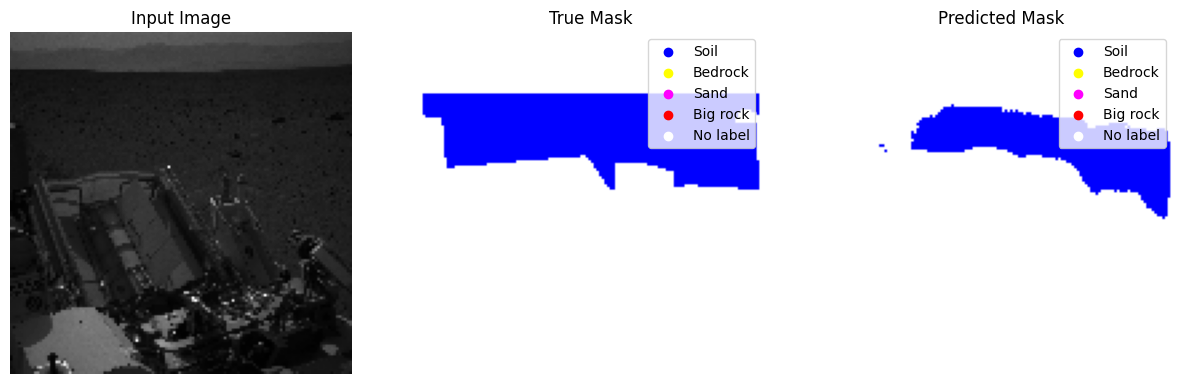

In [ ]:
show_predictions(train_dataset, 5)

In [ ]:
# Evaluate the model
loss, acc = unet.evaluate(test_images, test_labels, verbose=2)